In [6]:
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

## Part 1:  Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.


In [27]:
login = pd.read_json('logins.json')
login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [28]:
login.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [29]:
login.set_index('login_time', inplace=True)
login['login'] = 1

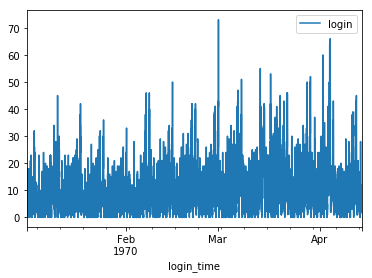

In [33]:
login.resample('15T').sum().plot()
plt.show()


#### There is not much we can see. Let's try decompose it into daily range.

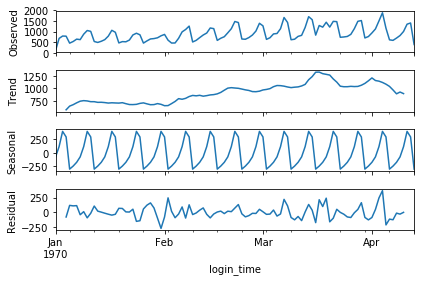

In [32]:
decom = sm.tsa.seasonal_decompose(login.resample('24H').sum())
decom.plot()
plt.show()

#### We can see there is absolutly a pattern in the Seasonal figure, it shows same daily trend reaptly.

#### Let's take a closer look into the first month and first week data.

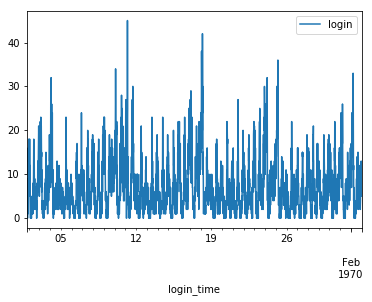

In [7]:
login.resample('15T').sum()['1970-01-01':'1970-02-01'].plot()
plt.show()

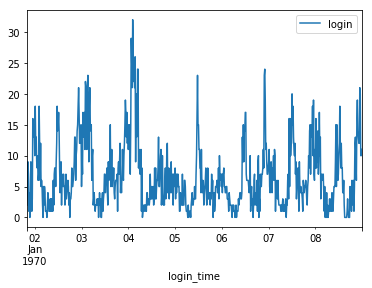

In [8]:
login.resample('15T').sum()['1970-01-01':'1970-01-08'].plot()
plt.show()

#### We already know there is possible weekly pattern and daliy pattern. Let's regroup the data by weekdays to check if there is more information.

In [34]:
resample_15 = login.reset_index().set_index('login_time').groupby(pd.Grouper(freq='15T')).count()

In [35]:
resample_daily_list = []
for group in resample_15.groupby(pd.Grouper(freq='D')):
    resample_daily_list.append(group[1])

In [36]:
#Create a list of the days to loop over, the data started on Thursday.
day_list = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']    

In [37]:
#Create a dict to hold the counts 
avg_index = defaultdict(int)
for i, t in enumerate(pd.timedelta_range(0, periods=24*4, freq='15T')):
    avg_index[i] = datetime.datetime.strptime(str(t).replace('0 days ',''), '%H:%M:%S').time()

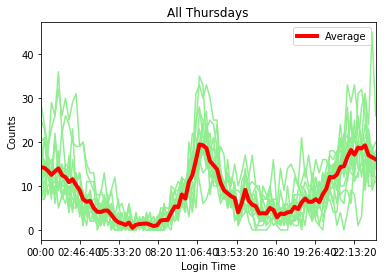

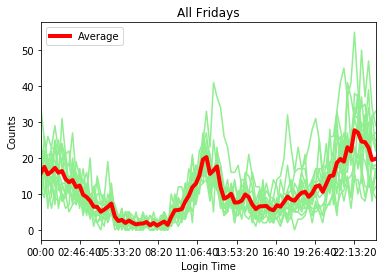

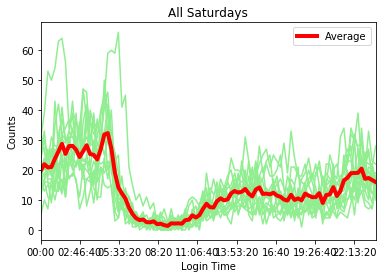

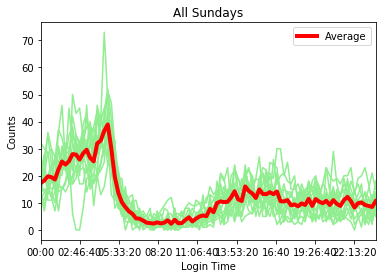

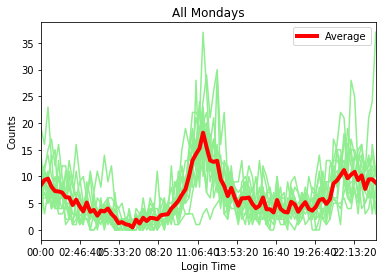

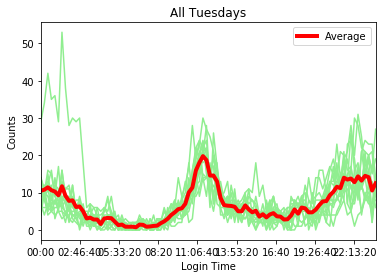

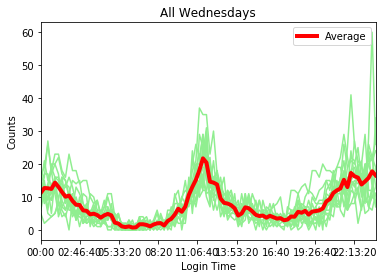

In [41]:
#Loop over the 7 days    
for i in range(len(day_list)):
    
    #Create the dataframe to hold the running counts
    avg_df = pd.DataFrame(avg_index.items(), columns=['login', 'login_time'])
    avg_df.login = 0
    avg_df.set_index('login_time', inplace=True)
    
    #Run through grouped day list
    day_range = range(i, len(resample_daily_list), len(day_list))
    for j in day_range:

        #Extract the dataframe
        df = resample_daily_list[j]
        df = df.set_index(df.index.to_series().dt.time)
        
        #Add the values of this dataframe to running count
        avg_df = avg_df.add(df, fill_value=0)              
        
        #Plot the time series
        if j < len(day_list):
            ax = df.plot(legend=False, color='lightgreen')
        else:
            df.plot(ax=ax, legend=False, color='lightgreen')
            
    #Create the average and plot    
    avg_df['Average'] = avg_df.login/float(len(day_range))
    avg_df.drop('login', axis=1, inplace=True)
    avg_df.plot(ax=ax, legend=True, color='red', lw=4.)
    
    #Plot the full graph
    ax.set_title('All ' + day_list[i] + 's')
    ax.set_xlabel('Login Time')
    ax.set_ylabel('Counts')
    plt.show()



#### Here we have the lightgreen areas show the actual login counts, while the red lines indicate the means of every Monday, Tuesday, etc.

### Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


#### My solution:
1. Given the experiment's goal, assuming all drivers either live in Gotham or Metropolis, I would choose the percentage of service times each driver accept orders in their city as a single KPI. This KPI should let us know whether the drivers are active equally in both city, no matter they drive part-time or full-time. If this experiment succeed, we should those drivers who were granted reimburshment have the KPI around 50%.

2. 
a. I would start to collect more data before launching this experiment. For exsample, the crime rate, tips collected from each city, accident rate, average speeding tickets per 10,000 drivers, etc. If we don't consider those factors, the result might be inaccurate. Then we can launch this experiment, make sure every user in our network knows. This experiment should last at least a month. Assuming the data is not polluted, and all other features are in a reasonable range, we can call out the experiment and start testing. Futhermore, we can keep monitoring the KPI after we canceled the reimbursing policy, to see if the KPI raises or not.

b. Assuming all other features were not significantly changed, I will simply use a z-test to see if the KPI was significantly changed after the experiment was launched. The null hypothesis should be: The KPI was not significantly changed. Alernative hypothesis should be: There was significant change on KPI.

c. Assuming the z-test result rejected the null hypothesis, we still need to carefully review what happened during the experiment. If the p-value showed there was a significant change on KPI, then we must check whether the change is positive or negative. Even if the change was positive, which means our incentive policy did help balancing the driver's activity, we can not ignore how much it cost. We need to compare the increased revenue and the extra toll cost we paid for the drivers. Furthermore, as we discovered above, the active time during weekdays and weekends are different. More work needs to be done before this experiment gets ready for further decision.

#### Something practical
To be honest, I don't think the solution above is practical enough. I'm considering build a ML model, add KPI and a new column which contains 0 and 1, each stands for with incentive and without. Also we should label our KPI, let's say KPI between 40% to 60% is labeled as 'balanced', the rest should be 'unbalanced'. Then we split our data into train, validate, and test. We train a ML model, make prediction on target label, then compute the AUC, RECALL, and Precision. If the model performs well, next step we will plot the feature importance. That's how we can find if the incentive policy is helpful enough or not.

### Part 3: Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


In [7]:
file = open('ultimate_data_challenge.json', 'r')
data = pd.DataFrame(json.load(file))
file.close()

In [44]:
data.signup_date = pd.to_datetime(data.signup_date)
data.last_trip_date = pd.to_datetime(data.last_trip_date)

data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [46]:
data.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [47]:
data['phone'].value_counts()


iPhone     34582
Android    15022
Name: phone, dtype: int64

In [48]:
data['city'].value_counts()


Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [8]:
data['avg_rating_by_driver'].fillna(data['avg_rating_by_driver'].mean(), inplace=True)
data['avg_rating_of_driver'].fillna(data['avg_rating_of_driver'].mean(), inplace=True)
data['phone'].fillna('iPhone', inplace=True)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [9]:
features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
            'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']

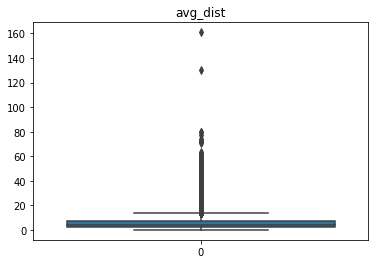

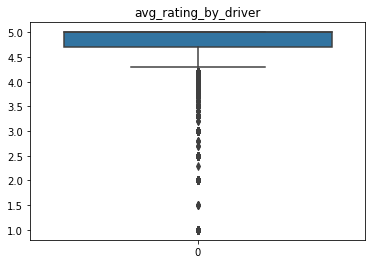

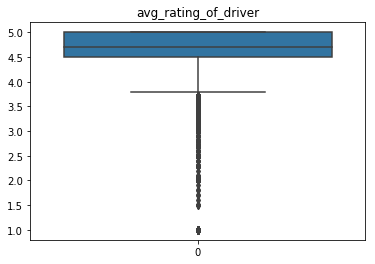

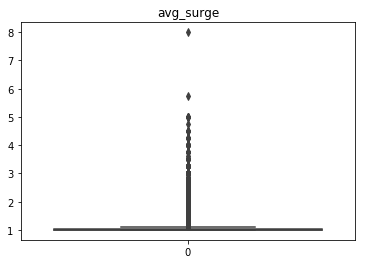

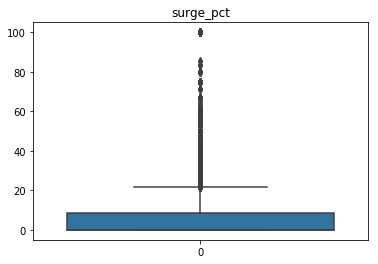

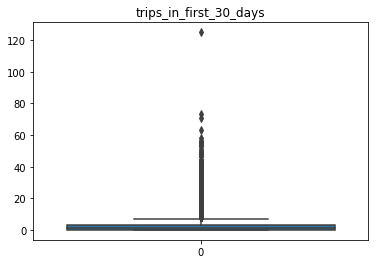

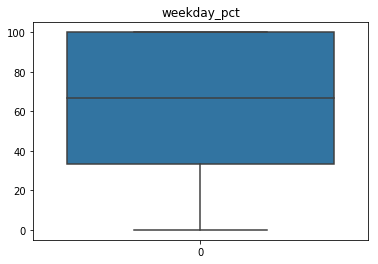

In [10]:
for feature in features:
    sns.boxplot(data=data[feature])
    plt.title(feature)
    plt.show();

In [11]:
def remove_outliers(df, col, num_sd=4.):
    return df[np.abs(df[col] - df[col].mean()) <= (num_sd * df[col].std())]


In [12]:
outlier = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 
                'trips_in_first_30_days']

for col in outlier:
    total = len(remove_outliers(data, col))
    print('%-25s : %i (%2.1f%%)' % (col, total, total*100./len(data)))
    

avg_dist                  : 49539 (99.1%)
avg_rating_by_driver      : 49652 (99.3%)
avg_rating_of_driver      : 49496 (99.0%)
avg_surge                 : 49272 (98.5%)
surge_pct                 : 48584 (97.2%)
trips_in_first_30_days    : 49441 (98.9%)


In [13]:
for col in outlier:
    data = remove_outliers(data, col)

data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 46672 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  46672 non-null float64
avg_rating_by_driver      46672 non-null float64
avg_rating_of_driver      46672 non-null float64
avg_surge                 46672 non-null float64
city                      46672 non-null object
last_trip_date            46672 non-null object
phone                     46672 non-null object
signup_date               46672 non-null object
surge_pct                 46672 non-null float64
trips_in_first_30_days    46672 non-null int64
ultimate_black_user       46672 non-null bool
weekday_pct               46672 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.3+ MB


In [14]:
data.corr()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
avg_dist,1.000000,0.097390,0.038336,-0.122072,-0.142580,-0.160879,0.034881,0.107787
avg_rating_by_driver,0.097390,1.000000,0.104941,-0.022025,-0.018065,-0.079856,0.000560,0.025317
avg_rating_of_driver,0.038336,0.104941,1.000000,-0.027270,-0.013987,-0.055689,-0.011381,0.008507
avg_surge,-0.122072,-0.022025,-0.027270,1.000000,0.848185,0.121179,-0.027039,-0.097765
surge_pct,-0.142580,-0.018065,-0.013987,0.848185,1.000000,0.127652,-0.044899,-0.110904
trips_in_first_30_days,-0.160879,-0.079856,-0.055689,0.121179,0.127652,1.000000,0.091580,0.032387
ultimate_black_user,0.034881,0.000560,-0.011381,-0.027039,-0.044899,0.091580,1.000000,0.024231
weekday_pct,0.107787,0.025317,0.008507,-0.097765,-0.110904,0.032387,0.024231,1.000000


In [15]:
sorted(data['last_trip_date'].unique())[:10]

['2014-01-01',
 '2014-01-02',
 '2014-01-03',
 '2014-01-04',
 '2014-01-05',
 '2014-01-06',
 '2014-01-07',
 '2014-01-08',
 '2014-01-09',
 '2014-01-10']

In [16]:
sorted(data['last_trip_date'].unique())[-10:]

['2014-06-22',
 '2014-06-23',
 '2014-06-24',
 '2014-06-25',
 '2014-06-26',
 '2014-06-27',
 '2014-06-28',
 '2014-06-29',
 '2014-06-30',
 '2014-07-01']

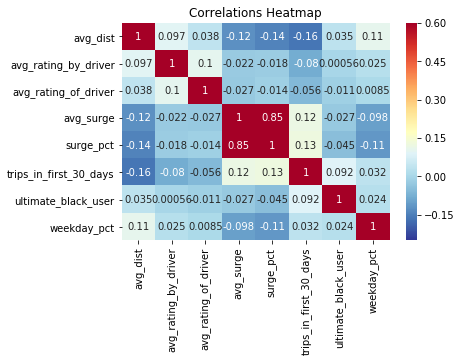

In [17]:
# Heatmap of correlations
sns.heatmap(data.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlations Heatmap');

#### The data was collected from 01/01/2014 to 07/01/2014, so we should determine active users by whether they took a ride in June or not.

In [18]:
# What's the percentage right now
print(len(data[data['last_trip_date'] >= '2014-06-01'])/len(data))

0.3836347274597189


In [19]:
# Create target column
data['is_active'] = np.nan
data.loc[data['last_trip_date'] >= '2014-06-01', 'is_active'] = 1
data.loc[data['last_trip_date'] < '2014-06-01', 'is_active'] = 0

In [20]:
data.drop('last_trip_date', axis=1, inplace=True)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46672 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  46672 non-null float64
avg_rating_by_driver      46672 non-null float64
avg_rating_of_driver      46672 non-null float64
avg_surge                 46672 non-null float64
city                      46672 non-null object
phone                     46672 non-null object
signup_date               46672 non-null object
surge_pct                 46672 non-null float64
trips_in_first_30_days    46672 non-null int64
ultimate_black_user       46672 non-null bool
weekday_pct               46672 non-null float64
is_active                 46672 non-null float64
dtypes: bool(1), float64(7), int64(1), object(3)
memory usage: 4.3+ MB


In [22]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score,classification_report
import warnings
warnings.filterwarnings('ignore')


In [23]:
def predict_labels(model, features, target):
    y_pred = model.predict(features)
    return roc_auc_score(target, y_pred)

In [24]:
df = pd.get_dummies(data, columns = ['city', 'phone', 'ultimate_black_user'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46672 entries, 0 to 49999
Data columns (total 16 columns):
avg_dist                     46672 non-null float64
avg_rating_by_driver         46672 non-null float64
avg_rating_of_driver         46672 non-null float64
avg_surge                    46672 non-null float64
signup_date                  46672 non-null object
surge_pct                    46672 non-null float64
trips_in_first_30_days       46672 non-null int64
weekday_pct                  46672 non-null float64
is_active                    46672 non-null float64
city_Astapor                 46672 non-null uint8
city_King's Landing          46672 non-null uint8
city_Winterfell              46672 non-null uint8
phone_Android                46672 non-null uint8
phone_iPhone                 46672 non-null uint8
ultimate_black_user_False    46672 non-null uint8
ultimate_black_user_True     46672 non-null uint8
dtypes: float64(7), int64(1), object(1), uint8(7)
memory usage: 3.9+ MB


In [25]:
df = df.drop(['signup_date'], axis=1)

In [26]:
X = df.drop(['is_active'],axis=1)
y = df['is_active']

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46672 entries, 0 to 49999
Data columns (total 14 columns):
avg_dist                     46672 non-null float64
avg_rating_by_driver         46672 non-null float64
avg_rating_of_driver         46672 non-null float64
avg_surge                    46672 non-null float64
surge_pct                    46672 non-null float64
trips_in_first_30_days       46672 non-null int64
weekday_pct                  46672 non-null float64
city_Astapor                 46672 non-null uint8
city_King's Landing          46672 non-null uint8
city_Winterfell              46672 non-null uint8
phone_Android                46672 non-null uint8
phone_iPhone                 46672 non-null uint8
ultimate_black_user_False    46672 non-null uint8
ultimate_black_user_True     46672 non-null uint8
dtypes: float64(6), int64(1), uint8(7)
memory usage: 3.2 MB


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
# Base Logistic regression
model = LogisticRegression(class_weight = 'balanced')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
# And finally: show the results
print(classification_report(y_test, y_pred))
print("Model has a training AUC score of %.4f"%(predict_labels(model, X_train, y_train)))
print('Model has a testing AUC score of %.4f'%(predict_labels(model, X_test, y_test)))

              precision    recall  f1-score   support

         0.0       0.79      0.72      0.75      5777
         1.0       0.60      0.69      0.64      3558

   micro avg       0.71      0.71      0.71      9335
   macro avg       0.69      0.70      0.70      9335
weighted avg       0.72      0.71      0.71      9335

Model has a training AUC score of 0.6941
Model has a testing AUC score of 0.7025


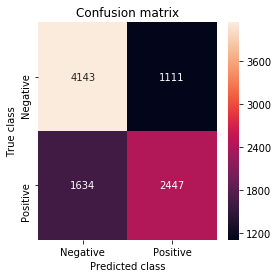

In [113]:
conf_matrx = confusion_matrix(model.predict(X_test), y_test)
plt.figure(figsize = (4,4))
LABELS = ['Negative','Positive']
sns.heatmap(conf_matrx, xticklabels = LABELS, yticklabels = LABELS,
           annot = True, fmt = 'd');
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()

In [114]:
searchCV = LogisticRegressionCV(Cs = [0.001,0.01,0.1,1,10,100], cv=5, penalty='l2', 
                                solver = 'lbfgs', random_state=42, class_weight='balanced')
searchCV.fit(X_train, y_train)
print("Model has a training AUC score of %.4f"%(predict_labels(searchCV, X_train, y_train)))
print('Model has a testing AUC score of %.4f'%(predict_labels(searchCV, X_test, y_test)))

Model has a training AUC score of 0.6936
Model has a testing AUC score of 0.7024


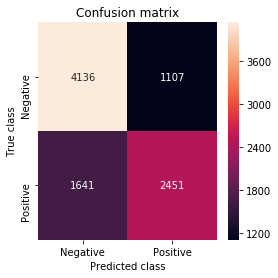

In [115]:
conf_matrx = confusion_matrix(searchCV.predict(X_test), y_test)
plt.figure(figsize = (4,4))
LABELS = ['Negative','Positive']
sns.heatmap(conf_matrx, xticklabels = LABELS, yticklabels = LABELS,
           annot = True, fmt = 'd');
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()

In [118]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {'bootstrap': [True],
              'min_samples_leaf': [2, 3, 4, 5],
              'min_samples_split': [2,3,4,5],
              'n_estimators': [1, 10, 50],
              'criterion': ['gini','entropy']}
# Create a based model
rf = RandomForestClassifier(max_features=14)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = 4)
grid_obj = grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
print(model.get_params, sep = '\n')
print("Model has a training AUC score of %.4f"%(predict_labels(model, X_train, y_train)))
print('Model has a testing AUC score of %.4f'%(predict_labels(model, X_test, y_test)))

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=14, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>
Model has a training AUC score of 0.8649
Model has a testing AUC score of 0.7552


In [119]:
print(classification_report(y_test, model.predict(X_test)))
print(confusion_matrix(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82      5777
         1.0       0.73      0.66      0.69      3558

   micro avg       0.78      0.78      0.78      9335
   macro avg       0.76      0.76      0.76      9335
weighted avg       0.77      0.78      0.77      9335

[[4884  893]
 [1192 2366]]


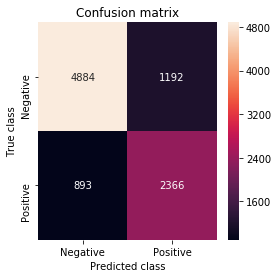

In [120]:
conf_matrx = confusion_matrix(model.predict(X_test), y_test)
plt.figure(figsize = (4,4))
LABELS = ['Negative','Positive']
sns.heatmap(conf_matrx, xticklabels = LABELS, yticklabels = LABELS,
           annot = True, fmt = 'd');
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()

1. feature avg_dist (0.202527)
2. feature avg_rating_by_driver (0.170043)
3. feature surge_pct (0.152921)
4. feature weekday_pct (0.112370)
5. feature city_King's Landing (0.094065)
6. feature trips_in_first_30_days (0.062180)
7. feature avg_rating_of_driver (0.061783)
8. feature avg_surge (0.031982)
9. feature phone_iPhone (0.025543)
10. feature phone_Android (0.024158)
11. feature ultimate_black_user_False (0.020550)
12. feature ultimate_black_user_True (0.019972)
13. feature city_Astapor (0.013274)
14. feature city_Winterfell (0.008632)


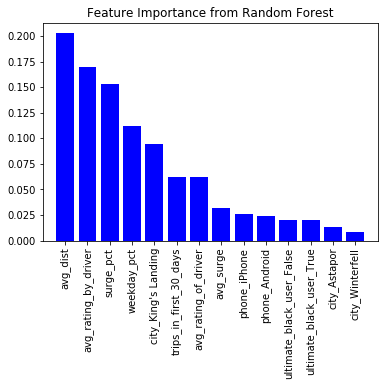

In [126]:
# Feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns.values
#print the feature ranking
for f in range(X.shape[1]):
    print("%d. feature %s (%f)"%(f + 1, features[indices[f]], importances[indices[f]]))
# plot the feature importances of the forest
plt.figure()
plt.title("Feature Importance from Random Forest")
plt.bar(range(X.shape[1]), importances[indices],
             color = 'b', align = 'center')
plt.xticks(range(X.shape[1]), features[indices], rotation = 'vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

### Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

From the feature importances figure above, we can see the top 3 features have relatively bigger influence on the retention. 
1. Avg_dist: This feature represent the rider's demand in their first month since signup. It is possible to say those riders who need Ultimate's service when they need a relatively long ride have higher retention rates. The Ultimate could run some incentive plan for new riders with long distance riding.

2. Avg_raing_by_driver: There is two ways to consider this feature. First, riders with high rating are comfortable with their trip, thay are more likely wo keep using Ultimate's service; second, riders with low but not too bad rating order more rides than other, they have higher demand on the ride, which also means they will keep using unless something changes in the future. We can determine that by check the correlation between this feature and the target.

3. Surge_pct: Same with avg_rating_by_driver, we need do more digging to see if the effect is positive or nagetive.

Conclusion: Ultimate should keep their eyes close to the feature importance over time, and make marketing strategies carefully based what we found here.